This code was made during the Datathon "Teach Artificial Intelligence to recognize Kyrgyz language" supported by The Cramer Project and Educational Initiatives Foundation. The main author of this code is our team's captain Aman Urumbekov (https://www.kaggle.com/amanurumbekov, https://github.com/Bezdarnost). Lately this challenge from the Datathon was posted on Kaggle too:https://www.kaggle.com/datasets/ilgizzhumaev/database-of-36-handwritten-kyrgyz-letters

In [1]:
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale = 1, rc={"grid.linewidth": 3})
pd.set_option('display.max_rows', 100, 'display.max_columns', 400)
from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision import transforms
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale = 1, rc={"grid.linewidth": 3})
pd.set_option('display.max_rows', 100, 'display.max_columns', 400)
from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision import transforms
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn

In [2]:
train_data=pd.read_csv('train_test.csv')
test_data=pd.read_csv('test.csv')
sample_data = pd.read_csv('sample_submission.csv')

In [3]:
print(train_data.info())
print('\n')
print(test_data.info())
print('\n')
print(sample_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80213 entries, 0 to 80212
Columns: 2501 entries, label to pixel_2499
dtypes: int64(2501)
memory usage: 1.5 GB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8904 entries, 0 to 8903
Columns: 2500 entries, pixel_0 to pixel_2499
dtypes: int64(2500)
memory usage: 169.8 MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8904 entries, 0 to 8903
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8904 non-null   object
 1   label   8904 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 139.2+ KB
None


In [4]:
train_df = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
test_df = test_data.values

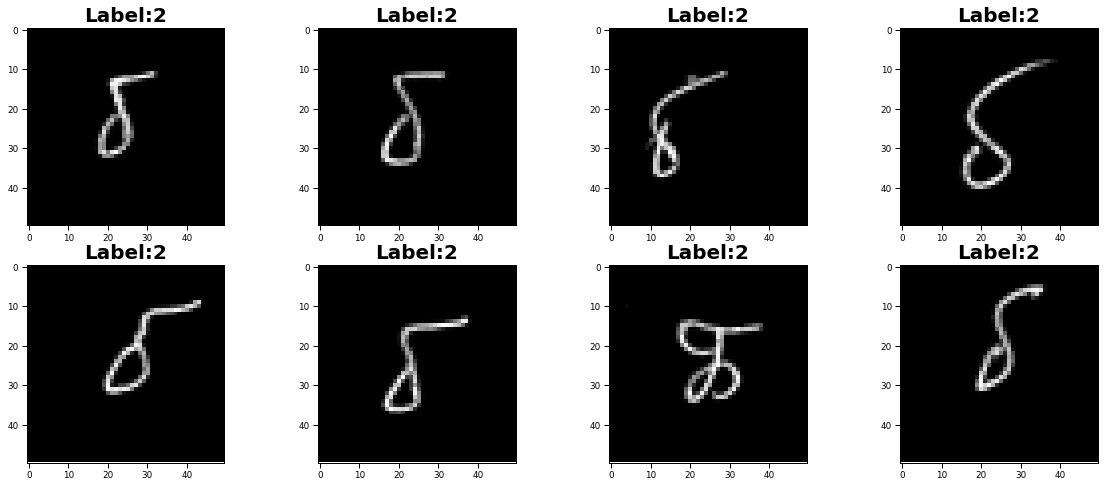

In [5]:
image_1 = train_df.reshape(train_df.shape[0], 50, 50) #rehsaping it to plot image
plt.figure(figsize=(20,8))
for i in range(10,18):
    plt.subplot(231 + (i))
    plt.imshow(image_1[i], cmap="gray")
    plt.title('Label:'+str(y_train[i]),fontweight='bold',size=20)

In [6]:
img_tform_1 = transforms.Compose([
    transforms.ToPILImage(),transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

img_tform_2 = transforms.Compose([
    transforms.ToPILImage(),transforms.RandomRotation(10),transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

img_tform_3 = transforms.Compose([
    transforms.ToPILImage(),transforms.RandomRotation(20),transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

In [7]:
class KyrMnistDataset(Dataset):
    def __init__(self, features,transform=img_tform_1): 
        self.features = features.iloc[:,1:].values.reshape((-1,50,50)).astype(np.uint8)
        self.targets = torch.from_numpy(features.label.values)
        self.transform=transform
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        return self.transform(self.features[idx]),self.targets[idx]

    
class TestDataset(Dataset):
    def __init__(self, features,transform=img_tform_1):
        self.features = features.values.reshape((-1,50,50)).astype(np.uint8)
        self.targets = None
        self.transform=transform
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        return self.transform(self.features[idx])

In [8]:
def create_dataloaders(seed, test_size=0.1, df=train_data, batch_size=32):

    train_df, val_df = train_test_split(df,test_size=test_size,random_state=seed)

    train_data_1 = KyrMnistDataset(train_df)
    train_data_2 = KyrMnistDataset(train_df, img_tform_2)
    train_data_3 = KyrMnistDataset(train_df, img_tform_3)

    train_final = ConcatDataset([train_data_1, train_data_2, train_data_3])

    val_data = KyrMnistDataset(val_df)
    
    train_loader = torch.utils.data.DataLoader(train_final, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),  #48x48x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True), # inplace=True helps to save some memory
            
            nn.Conv2d(64, 64, kernel_size=3), # 46x46x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=24), # 46x46x64 (same padding)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            
            nn.MaxPool2d(2, 2), #23x23x64
            nn.Dropout2d(0.25),
        
            nn.Conv2d(64, 128, kernel_size=3), #21x21x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True), 
            
            nn.Conv2d(128, 128, kernel_size=3), #19x19x128
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True), 
            
            nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=10), # 18x18x128(same padding)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            
            nn.MaxPool2d(2, 2),# 8x8x128
            nn.Dropout2d(0.25),
    
            nn.Conv2d(128, 256, kernel_size=8), # 1x256
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256*1*1, 37)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 256*1*1)
        x = self.fc(x)
        
        return x

In [10]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train() 
    final_loss = 0  
    train_acc=0
    total=0
    train_preds=[]
    
    for features,labels in dataloader:
        optimizer.zero_grad() 
        inputs, targets = features.to(device), labels.to(device) 
        outputs = model(inputs) 
        loss = loss_fn(outputs, targets) 
        loss.backward() 
        optimizer.step()  
        scheduler.step() 
        total+=len(targets)
        final_loss += loss.item() 
        train_preds.append(outputs.sigmoid().detach().cpu().numpy()) 
        _, predicted = torch.max(outputs, 1)
        train_acc+=((predicted == targets).sum().item())
    final_loss /= len(dataloader) 
    train_preds = np.concatenate(train_preds)
    train_acc=(train_acc/total)*100
    
    return final_loss,train_acc


def valid_fn(model, loss_fn, dataloader, device):
    model.eval() 
    final_loss = 0
    valid_preds = []
    val_acc=0
    total=0
    for features,labels in dataloader:
        inputs, targets = features.to(device), labels.to(device)
        outputs = model(inputs) 
        loss = loss_fn(outputs, targets) 
        total+=len(targets)
        final_loss += loss.item() 
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy()) 
        _, predicted = torch.max(outputs, 1)
        val_acc+=((predicted == targets).sum().item())
              
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    val_acc=(val_acc/total)*100
    
    return final_loss, valid_preds,val_acc

In [11]:
DEVICE = 'cuda'
EPOCHS = 12
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8
seed=42
#EARLY_STOPPING_STEPS = 10
#EARLY_STOP = False
#Dropout_model_val=0.2619422201258426

In [12]:
def run_training(seed):
    # train and data val dataloaders
    train_loader, valid_loader= create_dataloaders(seed=seed)
    model=Model()
    model.to(DEVICE)
    #using adam optimizer for optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e2, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(train_loader))
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(EPOCHS):
        train_loss,train_acc = train_fn(model, optimizer,scheduler, loss_fn, train_loader, DEVICE) #training loss and accuracy
        print(f"EPOCH: {epoch}, train_loss: {train_loss},, train_accuracy:{train_acc}")
        val_loss, val_preds, val_acc = valid_fn(model, loss_fn, valid_loader, DEVICE) #validation loss and accuracy
        print(f"EPOCH: {epoch}, valid_loss: {val_loss}, val_accuracy:{val_acc}")
        
    test_pred = torch.LongTensor()        
    testdataset = TestDataset(test_data)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    for features in testloader:
        features=features.to(DEVICE)
        outputs=model(features)
        _, predicted = torch.max(outputs, 1)
        test_pred = torch.cat((test_pred.to(DEVICE), predicted.to(DEVICE)), dim=0)
    pred_df['predict'] = test_pred.cpu().numpy()

In [ ]:
pred_df = sample_data.copy()
run_training(seed)

In [ ]:
final_pred = pred_df['predict']

In [ ]:
df1=pd.read_csv('sample_submission.csv')

In [ ]:
df1.drop(columns='label',inplace=True)

In [ ]:
df1['label']=final_pred

In [ ]:
df1.to_csv('12345.csv', index=False)